In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

In [4]:
def read_values_LJ():
    """
    paramaters
    ----------
    density : density of the system
    dx : displacement max
    T : temperature

    Returns
    -------
    parameters : dict
        Dictionary containing the parameters of the system
    results : dict
        Dictionary containing the tries, acceptances, overlaps and final energy
    all_positions : list
        List of the positions of the particles
    """
    parameters = {}
    results = {}
    all_positions = []
    for i in range(10):
        with open('./EX11_equilibration/run{}.xyz'.format(i), 'r') as file:
            lines = file.readlines()

        #Parameters are equal for each realization
        if i == 0:
            parameters["N"] = int(lines[0].split('=')[1].strip())
            parameters["N_steps"] = int(lines[1].split('=')[1].strip())
            parameters["box_x"] = float(lines[2].split('=')[1].strip())
            parameters["box_y"] = float(lines[3].split('=')[1].strip())
            parameters["box_z"] = float(lines[4].split('=')[1].strip())
            parameters["temperature"] = float(lines[5].split('=')[1].strip())
            parameters["delta_x"] = float(lines[6].split('=')[1].strip())
            parameters["myseed"] = int(lines[7].split('=')[1].strip())
            parameters["sigma"] = float(lines[8].split('=')[1].strip())
            parameters["model"] = int(lines[9].split('=')[1].strip())
            parameters["density"] = float(lines[13].split('=')[1].strip())
        
            results["tries"] = [int(lines[10].split('=')[1].strip())]
            results["accepted"] = [int(lines[11].split('=')[1].strip())]
            results["overlap"] = [int(lines[12].split('=')[1].strip())]
            results["E"] = [float(lines[14].split('=')[1].strip())]
            results["P"] = [float(lines[15].split('=')[1].strip())]

        else:
            results["tries"].append(int(lines[10].split('=')[1].strip()))
            results["accepted"].append(int(lines[11].split('=')[1].strip()))
            results["overlap"].append(int(lines[12].split('=')[1].strip()))
            results["E"].append(float(lines[14].split('=')[1].strip()))
            results["P"] = [float(lines[14].split('=')[1].strip())]
        # Parse the positions
        positions = []
        for line in lines[17:]:
            pos = list(map(float, line.split()[1:]))
            positions.append(pos)
        all_positions.append(positions)
    return parameters, results, all_positions


## Equilibration

Using code from exercise 8 to equilibrate the system

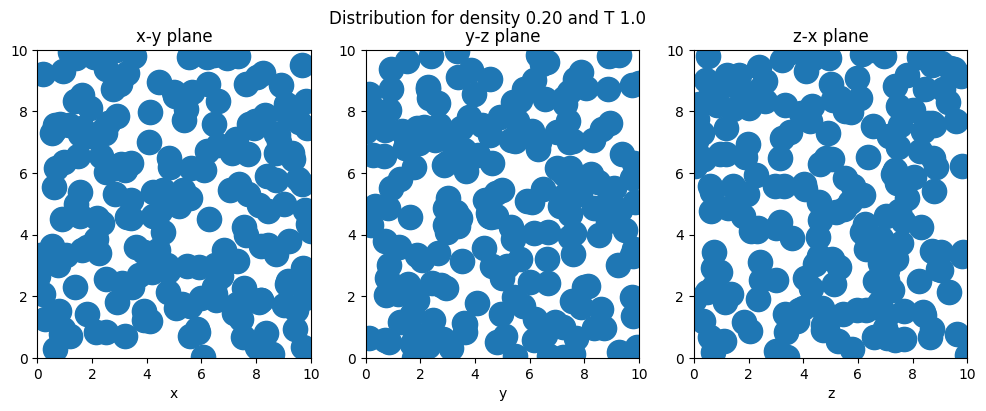

In [8]:
def plot_densities_2D():
    r_int = randint(0,9) #Plot one random realization
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    params, res, all_pos = read_values_LJ()
    T = params["temperature"]
    density = params["density"]
    for j in range(3):
        i_ax_vals_x = [pos[j] for pos in all_pos[r_int]]
        i_ax_vals_y = [pos[(j+1)%3] for pos in all_pos[r_int]]

        axes[j].set_xlim([0, params[f"box_{'xyz'[j]}"]])
        axes[j].set_ylim([0, params[f"box_{'xyz'[(j+1)%3]}"]])
        axes[j].set_title("{}-{} plane".format('xyz'[j], 'xyz'[(j+1)%3]))

        ax = axes[j]

        # Calculate the diameter in data units
        diameter_data_units = 1  # Change this to match your sigma

        # Calculate the diameter in display units
        diameter_display_units = np.diff(ax.transData.transform([(0, 0), (diameter_data_units, 0)]), axis=0)[0]

        # Convert the diameter from display units to points
        diameter_points = diameter_display_units[0] * 72 / plt.gcf().dpi

        # Calculate the area of the marker in points^2
        marker_area = np.pi * (diameter_points / 2)**2

        # Plot the data
        ax.scatter(i_ax_vals_x, i_ax_vals_y, s=marker_area)

    axes[0].set_xlabel('x')
    axes[1].set_xlabel('y')
    axes[2].set_xlabel('z')
    fig.suptitle("Distribution for density {:.2f} and T {:.1f}".format(density,T))

plot_densities_2D()


## Initial velocities

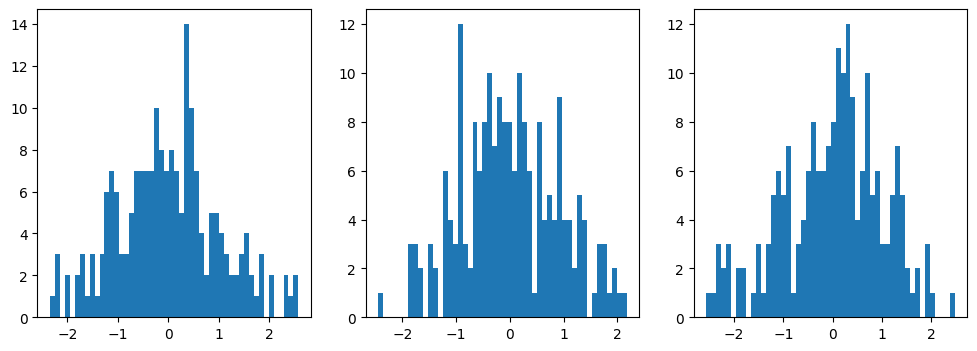

Mean vx = -0.00
Mean vy = -0.00
Mean vz = 0.00


In [26]:
velocities = np.loadtxt("./data/run1_v.xyz")
vx = velocities[:,0]
vy = velocities[:,1]
vz = velocities[:,2]

normal_dist = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
xs = np.linspace(-3, 3, 100)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(vx, bins=50)
axes[1].hist(vy, bins=50)
axes[2].hist(vz, bins=50)
plt.show()

print(r"Mean vx = {:.2f}".format(np.mean(vx)))
print(r"Mean vy = {:.2f}".format(np.mean(vy)))
print(r"Mean vz = {:.2f}".format(np.mean(vz)))

## Radial Distribution

In [64]:
def MinD(dx, L):
    if (dx > 6): 
        pass
    return dx - L*np.round(dx/L)

In [179]:
import numpy as np

def calculate_radial_distribution(particles, dr, max_r, L):

    # Initialize histogram
    bins = np.arange(0, max_r + dr, dr) #Adding a bin at the end for r>max_r
    hist = np.zeros(len(bins) - 1)

    # Calculate distances between all pairs of particles
    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            dx = MinD(particles[i][0] - particles[j][0],L)
            dy = MinD(particles[i][1] - particles[j][1],L)
            dz = MinD(particles[i][2] - particles[j][2],L)
            r = np.sqrt(dx**2 + dy**2 + dz**2)

            # Add to histogram/
            if r < max_r:
                bin_index = int(r // dr)
                hist[bin_index] += 2  # Each pair contributes to two particles

    # Normalize histogram to get g(r)
    tot_volume = L**3
    volume_shell = lambda r: 4/3 * np.pi * ((r+0.5*dr)**3 - (r-0.5*dr)**3) # Volume of a spherical shell with thickness dr.
    partial_density = np.array([hist[i]/volume_shell(bins[i]) for i in range(len(hist))])
    bulk_density = len(particles) / tot_volume
    g_r = partial_density / (bulk_density*(len(particles)-1))

    r = 0.5 * (bins[1:] + bins[:-1])
    return g_r, r
L = 10
max_r = np.sqrt(3*(L/2)**2)


(200, 3)


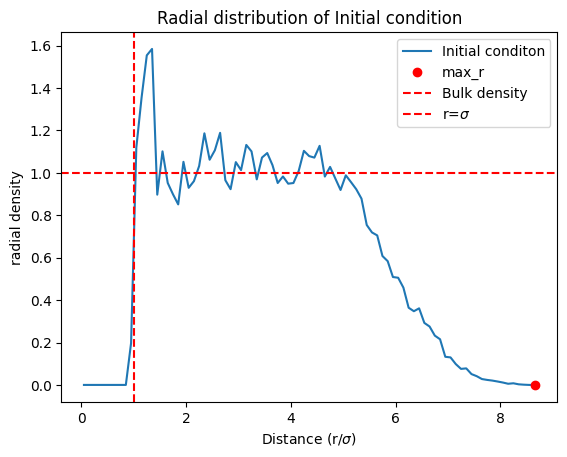

In [185]:
def plot_IC():

    parameters, results, all_positions = read_values_LJ()
    positions = all_positions[0]
    print(np.array(positions).shape)
    # Check if data is loaded correctly
    g_r, r = calculate_radial_distribution(np.array(positions), 0.1, max_r, L)
    plt.plot(r, g_r, label="Initial conditon")
    plt.plot(max_r, 0, 'ro', label='max_r')
    plt.axhline(y=1, color='r', linestyle='--', label='Bulk density')
    plt.axvline(x=1, color='r', linestyle='--', label=r'r=$\sigma$')
    plt.xlabel(r'Distance (r/$\sigma$)')
    plt.ylabel('radial density')
    plt.title('Radial distribution of Initial condition')
    plt.legend()
plot_IC()

Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)
Data loaded successfully. Shape of the data:  (200, 3)


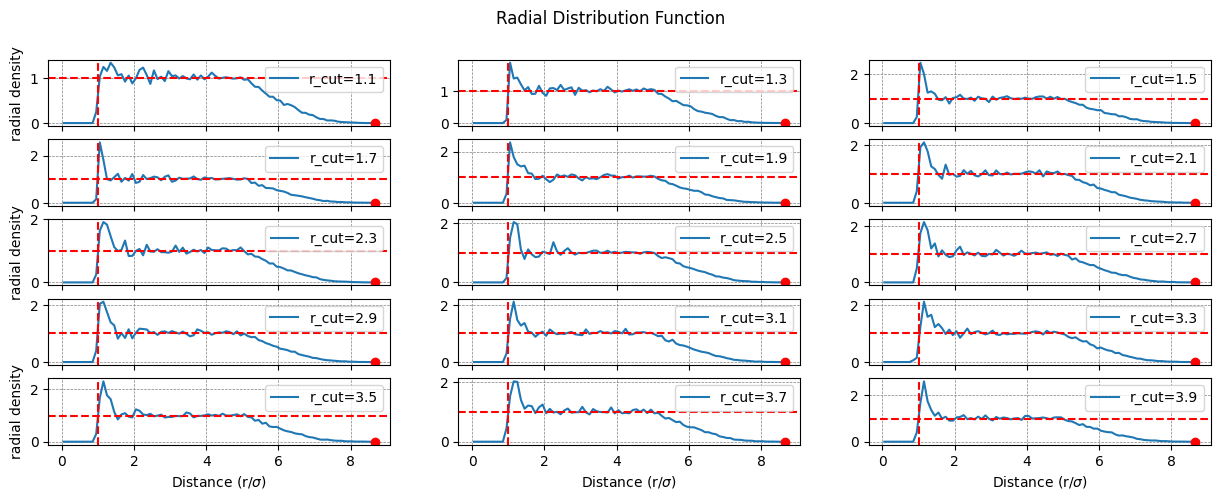

In [184]:
def plot_gr(dt):
    r_cut = np.linspace(1.1, 3.9, num=int((3.9-1.1)/0.2)+2)[:]
    fig, axes = plt.subplots(5,3, figsize=(15, 5))
    i = 0
    j = 0
    for rc in r_cut:
        positions = np.loadtxt("./data/dt={}/r_cut={:.6f}/run1_x.xyz".format(dt, rc))
        # Check if data is loaded correctly
        if positions.shape[0] > 0 and positions.shape[1] > 0:
            print("Data loaded successfully. Shape of the data: ", positions.shape)
        else:
            print("Data loading failed. Check the file path and format.")
        g_r, r = calculate_radial_distribution(positions, 0.1, max_r, L)
        axes[j][i].plot(r, g_r, label="r_cut={:.1f}".format(rc))
        axes[j][i].plot(max_r, 0, 'ro')#, label='max_r')
        axes[j][i].axhline(y=1, color='r', linestyle='--')#, label='Bulk density')
        axes[j][i].axvline(x=1, color='r', linestyle='--')#, label=r'r=$\sigma$')
        axes[j][i].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)  # Add this line
        axes[j][i].set_xlabel(r'Distance (r/$\sigma$)')
        if j % 2 == 0 and i == 0:  
            axes[j][i].set_ylabel('radial density')
        if j != 4:
            axes[j][i].set_xticklabels([])
        axes[j][i].legend()
        
        i += 1
        if i%3 == 0:
            j += 1
            i = 0
    fig.suptitle('Radial Distribution Function')
    
plot_gr(0.0001)

For low values of the cut of radius, the radial distribution tends to look like the initial distribution, which is just aligning as the uniform bulk density in the box.
As the cut off distance increases, there is a thendecy, quite early, to aglomerate the particles just above the radius of the spheres, $r = \sigma$, marked with a red dotted line.